# Omnibus Tests and Model Comparisons
In the previous section, we saw how to use dummy variables with multiple categorical levels and then specify a subsequent regression model that fits group means and mean differeces. Although we called this a One-way ANOVA model, it probably does not look much like an ANOVA to you yet. In this section, we will complete the picture by discussing the nature of the ANOVA omnibus tests and showing how these are effectively *model comparisons*. The familiar ANOVA table is simply a way of displaying the results of several model comparisons. We will show how to generate this within `R` and also show how the values within this table relate to comparing different regression models.

## ANOVA as a Model Comparison Procedure
In order to understand the ANOVA within the framework of linear models, we need to demonstrate how the ANOVA results are simply the outcomes from comparing different linear models in a specific way. To begin, we need to consider the logic of an *omnibus test*. 


### Omnibus Tests
An omnibus test is a test that contains *multiple* comparisons between means. In comparison to a procedure such as a $t$-test, which only compares *two* means, an omnibus test can compare *multiple* means. In our example of a One-way ANOVA where $k = 3$, the omnibus null hypothesis is

$$
\mathcal{H}_{0} : \mu_{1} = \mu_{2} = \mu_{3}.
$$

In other words, the null is that *all* the means are identical. Or, to put it another way, that all the mean differences are 0. An omnibus test of this hypothesis is able to simultaneously compare *all possible mean differences*. Within the NHST framework, a significant omnibus effect suggests that *at least one* of all possible mean differences is significant. Traditionally, we would then drill-down to see which of the differences is driving the omnibus effect[^omnibus-foot].

```{admonition} What is the point of an omnibus test?
:class: tip, dropdown
At this point, you may well ask: what is the point of an omnibus test? If we just end up drilling-down to work out which differences are significant, why not just start there? Why even both with the omnibus test? 

The traditional argument is one of *error control* in relation to the problem of *multiple testing* or *multiple comparisons*. If our categorical variable has $k$ levels, then there are $m = \frac{k(k-1)}{2}$ comparisons we can make between the levels. If our desired error level is given by $\alpha$, then across all tests the probability of *at least one* being significant is $1 - (1 - \alpha)^{m}$. This is known as the *familywise error rate* (FWER). So, notice that whenever $m > 1$ our desired error-rate will be scaled by the number of tests and therefore get *bigger*. 

As an example, if we take $k = 5$, $m = 10$ and $\alpha = 0.05$, the FWER is 

$$
\text{FWER} = 1 - (1 - \alpha)^{m} = 1 - 0.95^{10} = 0.40.
$$

This means there is now a 40% chance of a significant effect under the null, rather than a 5% chance. This is the *multiple testing* problem. The more levels our categorical predictor has, the worse this gets. This is where an omnibus test helps because, irrespective of the value of $k$, the FWER stays at the desired $\alpha$ because it is only a *single test*. So, we can have a factor with many levels and can assess all the differerences simultaneously using a single test that does not inflate the FWER.

It is worth noting as well that multiple testing is really a problem of NHST and frequentist statistics. Because of these approaches, there is a sense that traditional statistical inference actively *punishes* researchers for wanting to investigate and explore their data. This is not universal of all statistical methods. For instance, Bayesian statistics allows as many comparisons as you want without disturbing the probabilistic structure of the conclusions. So just know that ominbus tests and the multiple comparisons problem are not *universal* in statistics, rather they are a consequence of one particular school of thought and one particular definition of probability.
```

### Omnibus Tests From Model Comparisons
So, how do we generate omnibus tests from model comparisons? To see how this works, consider that the omnibus null hypothesis above actually *implies* a specific model. If it were true that all the group means are identical, then the grouping variable is effectively meaningless. It has simply chopped the data up randomly into 3 groups. Assuming that the population means of the groups are all the *same* implies that all the data are drawn from the *same population distibution*. Thus, rather than assuming

$$
y_{ij} \sim \mathcal{N}\left(\mu_{j},\sigma^{2}\right)
$$

we are assuming

$$
y_{i} \sim \mathcal{N}\left(\mu,\sigma^{2}\right).
$$

Here we have *two different models*. One that just assumes a single mean for all the data and one that assumes *different* means for the different groups. In the context of a regression model, this is a comparison between a model that only contains an intercept, and a model containing an intercept *and* dummy variables for the categories. Typically, these are called the *null model* and the *full model*, so we have

$$
\begin{align*}
    \mathcal{M}_{0} &: y_{i\phantom{j}}  = \mu_{\phantom{j}}     + \epsilon_{i}  &\quad \text{Null Model} \\
    \mathcal{M}_{1} &: y_{ij} = \mu_{j} + \epsilon_{ij} &\quad \text{Full Model} \\
\end{align*}
$$

In `R`, sticking with our `mtcars` example, we could specify these in the following way

In [2]:
data(mtcars)
mtcars$origin <- c('Japan','Japan','USA','USA','USA','USA','USA','Europe','Europe',
                   'Europe','Europe','Europe','Europe','Europe','USA','USA','USA',
                   'Europe','Japan','Japan','Japan','USA','USA','USA','USA',
                   'Europe','Europe','Europe','USA','Europe','Europe','Europe')
mtcars$origin <- as.factor(mtcars$origin)

In [3]:
null.mod <- lm(mpg ~ 1,      data=mtcars) # null model
full.mod <- lm(mpg ~ origin, data=mtcars) # full model

Thus, the full model contains our categorical variable of interest and the null model does not. If our question revolves around whether this predictor is actually necessary, a natural way to do so would be to compare how well each model fits the data. If the null and full model have a similar model fit, then it suggests that `origin` is doing little more than an intercept. In other words, the groups means appear largely identical. Alternatively, if the full model fits much better than the null model then it suggests that allowing the group means to differ is a more accurate reflection of the data. In other words, at least two of the group means appear to be different.

### Model Comparisons Using Sums-of-Squares
In order to compare the model fits, the most intuitive method would be to calculate the the magnitude of the residual variance of each model and compare them. If a model fits better, its residual variance will be smaller. In other words, the average degree to which the data deviates from the model prediction will be reduced. Unfortunately, there is a numeric problem with this. What we really want to do is figure out how much the model has improved between the null and the full. In other words, what is the magnitude of variance associated with our effect of interest. Intutively, what we might think about doing is calculating

$$
\Delta\sigma^{2} = \sigma^{2}_{\text{null}} - \sigma^{2}_{\text{full}}.
$$

At the level of the *population*, this would work. However, at the level of *sample estimates*, this is a messy quantity that does not cleanly isolate the improvement added by the full model. To see why, consider the expanded definition of the variances as calculated from a sample

$$
\Delta\hat{\sigma}^{2} = \underbrace{\frac{\sum{\epsilon_{0}^{2}}}{n - p_{0}}}_{\hat{\sigma}^{2}_{\text{null}}} - \underbrace{\frac{\sum{\epsilon_{1}^{2}}}{n - p_{1}}}_{\hat{\sigma}^{2}_{\text{full}}},
$$

where $\epsilon_{0}$ and $\epsilon_{1}$ are the residuals from the null and full models, and $p_{0}$ and $p_{1}$ are the number of parameters from the null and full models. Written this way, it is clear that we are subtracting quantities with different denominators. If we had the whole population at our disposal, each quantity would be divided by $n$ and there would be no problem. However, because these are *estimates*, we lose a degree of freedom for each parameter we have to estimate. Because the full and null models have different numbers of parameters, this makes the final value very unclear in terms of what it is actually telling us about the differences between these models. This is precisely because, in a sample, the individual terms are scaled differently. As such, even if the model fits were *identical*, we may still see a difference here due to differences in the number of parameters.

The solution then is to *not* use the residual variances to compare the models, despite its intuitive appeal. Instead, we forego the denominators entirely to give

$$
SS_{\text{effect}} = \sum{\epsilon_{0}^{2}} - \sum{\epsilon_{1}^{2}}.
$$

This value is more usually known as the *between-groups sum-of-squares* ($SS_{B}$) and is formed from the *residual sum-of-squares* (RSS) from each model. The logic is that we cannot isolate the magnitude of the model improvement by using the sample error variances because

$$
\hat{\sigma}^{2}_{\text{effect}} \neq \hat{\sigma}^{2}_{\text{null}} - \hat{\sigma}^{2}_{\text{full}}.
$$

But we *can* using the sums-of-squares because

$$
SS_{\text{effect}} = RSS_{\text{null}} - RSS_{\text{full}}.
$$

This is a direct consequence of removing the messiness of the denominators from the calculation.

Let us see this in practice for our two example models. In the code below, we can calculate the residual sums-of-squares as a measure of each model fit. The *larger* the value, the more error remains and the *worse* the model fits the data.

In [4]:
null.RSS <- sum(resid(null.mod)^2)
full.RSS <- sum(resid(full.mod)^2)

print(c(null.RSS,full.RSS))

[1] 1126.0472  732.1721


So, we can see already that the null model has a larger RSS and thus is a worse fit to the data. The difference between these values therefore tells us how much the error *reduces* after including `origin` in the model.

In [5]:
SS.B <- null.RSS - full.RSS

print(SS.B)

[1] 393.8751


How do we interpret this value? Generally, we cannot because the units are not any sort of standardised scale. However, what we can do is compare this value *relative* to some other measure on the same scale. What measure to use? Well, at present, the $SS_{B}$ gives us a sense of how much we have reduced the error of the null model by including a specific predictor. What we want to know is whether this is *large* or *small*? More generally, we want to know whether any improvement we have seen is likely to be random noise (in which case the predictor has done *nothing* to help the model) or whether it implies something more systematic about the data (i.e. that the population means differ across the groups).

So, we need some measure of noise to compare $SS_{B}$ to. In general, we have two options: $RSS_{\text{null}}$ or $RSS_{\text{full}}$. These are both sums-of-sqaures that reflect the *error* or *noise*, as they capture the degree of variability that is left-over within each model. If it were the case that the predictor was *not* related to the data then these quantities would be similar. However, if the predictor *was* related to the data then the null model would be missing a key component and its error would be larger than it should be. This would make $RSS_{\text{null}}$ a poor comparison. Because of this, $RSS_{\text{full}}$ becomes the much better choice. If the predictor *does* relate to the data then $RSS_{\text{full}}$ will be the correct magnitude, but if the predictor *does not* relate to the data then $RSS_{\text{full}}$ will be similar to $RSS_{\text{null}}$. So either way, $RSS_{\text{full}}$ becomes the better measure of *error* or *noise*.

Within the context of an ANOVA model, $RSS_{\text{full}}$ is more usually known as the *within-group sum-of-squares*, or $SS_{W}$ for short, because it effectively measures variability in terms of individual subjects around the group means. In other words, how well do the group means fit the data? Within our example in `R`, we already calculated $RSS_{\text{full}}$ and so can simply copy it to a new variable with a different name.

In [6]:
SS.W <- full.RSS
print(SS.W)

[1] 732.1721


### The $F$-ratio
Given what we have discussed above, we could just eye-ball the magnitude of $SS_{B}$ relative to $SS_{W}$. However, a more principled approach is to combine these values into some sort of *test statistic*, akin to the $t$-statistic we have discussed previously. In doing so, we can combine the two sources of information into a single standardised value that can be interpreted across different datasets. Much in the same way that a $t$-statistic is formed by dividing an *effect* by *error*, we could similarly form a statistic by calculating $\frac{SS_{B}}{SS_{W}}$. This would tell us how large the improvement in model fit is, relative to the amount of error left over. 

The statistic we use for this purpose is known as $F$ (named after *Fisher*). Given the description above, it may seem like we could calculate $F = \frac{SS_{B}}{SS_{W}}$. However, there is some additional complexity. Although both $SS_{B}$ and $SS_{W}$ appear to be compatible, because they are both sums-of-squares, they cannot be directly compared. This is because they are both *sums*, and so their magnitude is dependant upon whatever we are summing over. If they were both summed over the same element of the model, there would be no problem. But this is not the case. As we will see below, the magnitude of $SS_{B}$ depends upon the number of model parameters, yet the magnitude of $SS_{W}$ depends upon the sample size. So both terms need to be *scaled* first, to make them truly comparable. These scaled values are known as *mean squares*.

#### Mean-squares
Starting with $SS_{B}$, this value can be interpreted as the improvement in model fit after adding a certain number of parameters to the model. Unfortunately, this value will always scale with the number of parameters we add. This is because the more parameters we add, the better the fit can become. The most extreme example of this is having one parameter for every observation. In this case, we could make the model fit *perfectly* with no error. Thus, we can always make the model better and better by adding more and more parameters[^overfit-foot]. The problem is that we do not know whether $SS_{B}$ is large because of a genuine improvement to the model fit, or simply because we have added more parameters. 

To make this value more meaningful, we can therefore divide it by the number of parameters we have added to give an *average improvement per-parameter*. This has the advantage of turning the sums-of-squares back into a measure of variance, but one that is now correctly calculated to give $\hat{\sigma}^{2}_{\text{effect}}$. The number of additional parameters is known as the *numerator degrees of freedom* (or $df_{1}$) and the scaled version of $SS_{B}$ is known as the *between-group mean square*, or $MS_{B}$ for short. As such 

$$
MS_{B} = \frac{SS_{B}}{df_{1}} = \frac{SS_{B}}{k - 1} = \hat{\sigma}^{2}_{\text{effect}}.
$$

In the case of the `mtcars` example, we need to add $k - 1 = 2$ parameters to the model to capture the different group means. As such, we divide $SS_{B}$ by $df_{1} = 2$ to produce the $MS_{B}$

In [7]:
df.1 <- 2
MS.B <- SS.B / df.1
print(MS.B)

[1] 196.9376


So, we have an improvement in model fit in terms of reducing the error variance by an average of 196.94 for each parameter we have added.


Moving on to $SS_{W}$, we have a similar problem because this value always scales with *sample size*. Remember, this is simply the residual sum-of-sqaures for the full model. As such, the more residuals we have, the larger the sum will be. As noted above for $SS_{B}$, we therefore do not know whether $SS_{W}$ is large because the model fit is poor, or because we have a large $n$.

Using a similar logic to above, it would seem that we could just divide $SS_{W}$ by $n$. However, there is a catch. Remember that dividing a sums-of-squares by some value gives us a *mean-square*, but that mean-squares are effectively *variances*. So what variance do we get from the residual sum-of-squares? As covered in previous weeks, this is simply the estimated *error variance* of the model, $\hat{\sigma}^{2}$. However, we also know from previous weeks that dividing by $n$ leads to a *biased* estimate of the population variance and that, as a generalisation of Bessel's correction, we must divide by $n-p$. As such, rather than dividing $SS_{W}$ by $n$, we divide by $n-p$, which gives the *denominator* degrees of freedom $df_{2} = n - p$. This gives the *within-groups mean-square*, or $MS_{W}$ for short 

$$
MS_{W} = \frac{SS_{W}}{df_{2}} = \frac{SS_{W}}{n-p} = \hat{\sigma}^{2}_{\text{error}}.
$$

We can see this in our `mtcars` example

In [ ]:
df.2 <- full.mod$df.residual # this is always n - p
MS.W <- SS.W / df.2
print(MS.W)

[1] 25.24731


Which, as already indicated, is *identical* to the error variance from the full model.

In [9]:
sigma <- summary(full.mod)$sigma
print(sigma^2)

[1] 25.24731


This gives us the left-over variance after fitting the full model. So together, we have a reduction in residual variance of 196.94 after adding `origin` to the model, with only a residual variance of 25.25 left over. If our reduction in variance were of a similar magnitude to the amount left over, we could not say with any certainty that it was a true effect because the "effect" and the "error" look basically the same. However, in this case, the reduction in error variance is *much larger* than the amount left over, which is already suggestive of some true effect and thus that including `origin` in the model allows for a much better model fit. Because the `origin` factor allows for the group means to differ, this implies that *at least* one pair of group means are different from each other. This connects this result directly to our original omnibus hypothesis.

```{admonition} What's in a name?
:class: tip
As we can see, some of the confusion around ANOVAs and ANOVA calculations simply comes down to using *different names* for familiar quantities. The name ANOVA tells us that the method involves comparing variances, yet those variances are called *mean-squares*. Usually, we would not give a name to the intermediate quantities produced during the calculation of variances, but the ANOVA names them as *sums-of-squares*. These quantities take on more importance within an ANOVA, because the sums-of-squares are the only meaningful way to compare two model fits, before they can be scaled back into variances. However, this creates a confusing collection of sums-of-squares, mean squares and degrees of freedom. 

*Remember*, all we are doing is comparing two models using their residuals. That is it. Try not to get too lost in the specifics of *how* this is done and keep focus on the very simple aim of the ANOVA. Remember as well that the ANOVA table was introduced by Fisher as a convenient way of organising all the arithmetic. The table was designed to make the calculations less confusing, but the table is *not* the ANOVA itself. There is nothing in an ANOVA table that implies any form of model comparison, but this is exactly what it is showing. As we will see below, in `R` such a table can be produce by *directly* comparing two models, making this perspective event clearer.
```

#### The Definition of $F$
So, given everything we have discussed above, we have taken a rather long and winding road to the definition of the $F$-statistic, which is:

$$
F = \frac{SS_{B} / df_{1}}{SS_{W} / df_{2}} = \frac{MS_{B}}{MS_{W}} = \frac{\hat{\sigma}^{2}_{\text{effect}}}{\hat{\sigma}^{2}_{\text{error}}}.
$$

At its most basic, the $F$-ratio is compaing two measures of variance. Hence the name, Analysis of *Variance*. If we want to make this even simpler, we can say 

$$
F = \frac{\text{Improvement in error between the null and full models}}{\text{Error remaining}}.
$$

Or, to put this a difference way, how much variance have we managed to explain for each parameter we have added compared to how much we still have left to explain?

Given that $F$ is a *ratio*, we can think of its value in fairly simple terms. If $F = 1$ then the magnitude of the improvement is the same as the magnitude of the error. This is what we would expect if the null hypothesis were true, because any improvement is indistinguishable from normal sampling error. However, if $F > 1$, it means that the improvement is much larger than the error. The bigger this value becomes, the more the improvement dwarfs the error and the harder it becomes to believe that all we have captured is noise.

Because the $F$ is the ratio of two *estimates* ($\hat{\sigma}^{2}_{\text{effect}}$ and $\hat{\sigma}^{2}_{\text{error}}$), and because each estimate is a *random variable*, the $F$-ratio itself is a random variable with some distribution. Under the null hypothesis that there is no effect, $\sigma^{2}_{\text{effect}} = \sigma^{2}_{\text{error}}$ and the $F$-ratio will be 1 on average, as indicated above. The null $F$-distribution therefore has a form where the expected value is 1. This makes the null $F$-distribution only *one-tailed*, as illustrated below for an example $F_{2,29}$.

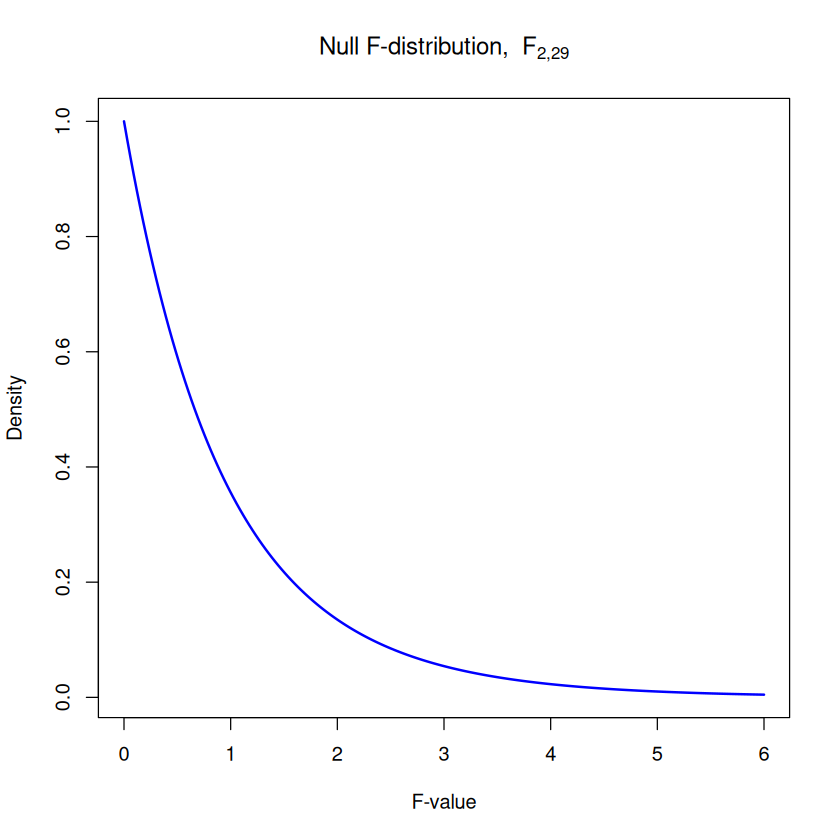

In [1]:
# Parameters
df1 <- 2   # numerator degrees of freedom
df2 <- 29  # denominator degrees of freedom

# Range of F values to plot
x <- seq(0, 6, length.out = 200)  # up to ~6 is enough for df1=2, df2=30

# Density of the F-distribution
y <- df(x, df1, df2)

# Plot
plot(x, y, type = "l",
     lwd = 2, col = "blue",
     main = bquote("Null F-distribution, " ~ F[2*","*29]),
     xlab = "F-value", ylab = "Density")

If we are following NHST convention, we can therefore compare the value of $F$ we have calculated to the null distribution and produce an associated $p$-value. As with the $t$-statistic, the larger $F$ becomes, the less probable it is if the null were true and thus the *smaller* the $p$-value becomes.

#### Summary of Calculations

Because the steps needed to calculate $F$ are quite involved, we have summarised all of them in the `R` code below. This will hopefully make it clear that we are really comparing two models to each other, it is just that we have to go about it in a slightly complicated way in order for the numbers to make sense. Also, do not worry, we will see how to automate all of this in `R` very shortly.

In [20]:
# Null model and full model
null.mod <- lm(mpg ~ 1,      data=mtcars)
full.mod <- lm(mpg ~ origin, data=mtcars)

# Residual sums-of-squares
null.RSS  <- sum(resid(null.mod)^2)
full.RSS  <- sum(resid(full.mod)^2)

# Sums-of-squares
SS.B <- null.RSS - full.RSS # between-groups (model improvement)
SS.W <- full.RSS            # within-groups (error)

# Mean-squares
df.1 <- 2
df.2 <- full.mod$df.residual # (n-p)
MS.B <- SS.B / df.1          # reduction in error variance (effect)
MS.W <- SS.W / df.2          # remnaining error variance (error)

# F-ratio
F <- MS.B / MS.W

# p-value from null F-distribution with df1 and df2
p <- pf(q=F, df1=df.1, df2=df.2, lower.tail=FALSE)

# Results
print(data.frame("F.ratio"=F, "p.value"=p), row.names=FALSE)


  F.ratio     p.value
 7.800338 0.001946794


The value of $F$ indicates that the reduction in error between the null and full model is nearly 8 times *larger* than we would expect, if this effect was just noise. In other words, this is nearly 8 times bigger than our expectation under the null hypothesis of no differences between the group means. The probability of achieving a value of $F_{2,29} = 7.80$ if the null were true is $p = 0.002$, which is below the usual NHST threshold of $p = 0.05$, thus this would be declared "significant" within this framework. In terms of our omnibus hypothesis, this is taken to imply that *at least one* of the mean differences between the levels of `origin` is also significant.

## ANOVA Tables in `R`

### The `anova()` Function

In [11]:
print(anova(null.mod, full.mod))

Analysis of Variance Table

Model 1: mpg ~ 1
Model 2: mpg ~ origin
  Res.Df     RSS Df Sum of Sq      F   Pr(>F)   
1     31 1126.05                                
2     29  732.17  2    393.88 7.8003 0.001947 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Within this table, we should see all the values that we calculated manually above, alongside the $p$-value for the $F$-ratio.

In [12]:
print(drop1(full.mod, test="F"))

Single term deletions

Model:
mpg ~ origin
       Df Sum of Sq     RSS    AIC F value   Pr(>F)   
<none>               732.17 106.17                    
origin  2    393.88 1126.05 115.94  7.8003 0.001947 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### The `Anova()` function

In [13]:
library(car)
print(Anova(full.mod))

Loading required package: carData



Anova Table (Type II tests)

Response: mpg
          Sum Sq Df F value   Pr(>F)   
origin    393.88  2  7.8003 0.001947 **
Residuals 732.17 29                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


... Notice that this table says `Type II tests` at the top. This is something we will explore in more detail in the associated synchronous session next week.

... So, the core understanding here is that the ANOVA is simply a *model comparison procedure*. The ANOVA effects usually reported within an ANOVA table are really comparisons between a model that contains that effect and a model that does not contain that effect. The *variance* within the name ANOVA is a comparison between the error variances of these models. In other words, the ANOVA is asking the question "how much does the error reduce when we include this effect in the model?" The table is just a helpful way of organising all these comparisons. So we can see that the ANOVA model is in fact just a form of multiple regression, and the tests associated with the ANOVA are summaries of model comparisons. This is the true way to conceptualise an ANOVA.

## The Regression ANOVA $F$-test
... In fact, this test is already provided at the bottom of the regression table...

Note that this will not always align with the ANOVA tests we want. For simple models that only contain a single factor and *nothing else*, the regression ANOVA test will be equivalent to an omnibus test on that single factor. For models that contain *multiple* factors and/or continuous predictors, this will not be equivalent. As such, it can be good practise to produce the ANOVA table anyway, even if in some cases it is redundant.

[^overfit-foot]: You may wonder what the problem is with this. Surely we want the model to fit as well as possible? However, a *perfect* fit suggests *over-fitting*. Remember, our aim is to use our model to separate those effects that are universal to our population of interest from the noise. A model that fits one specific dataset does not do this. In fact, it will be fitting *both* the effects we are interested in *and* the noise. This may result in a perfect fit for that specific dataset, but it tells us nothing about our population of interest and certainly would not fit another sample very well.